In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from sklearn import set_config
set_config(display="text")

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
# Criei um pipeline pra usar o PolynomialFeatures (regressor) junto como o RobustScaler (preprocessamento)
pipeline_robust = Pipeline([
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler),
    ],
)

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [10]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
}

In [11]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                          

In [12]:
grid_search.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                          

In [13]:
grid_search.best_params_
# Vemos que o alfa pego foi o melhor, ou seja, houve uma grnade regularização

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 20.0}

In [14]:
grid_search.best_score_ # Houve uma melhora considerável

np.float64(-50445.067963107875)

In [15]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-0.889830
robust_scaler_poly__latitude,-0.794406
one_hot__ocean_proximity_INLAND,-0.498202
robust_scaler_poly__population_per_household,-0.333378
robust_scaler_poly__latitude^2,-0.290944
...,...
robust_scaler_poly__housing_median_age longitude^2,0.192571
robust_scaler_poly__latitude median_income population_per_household,0.217551
robust_scaler_poly__housing_median_age median_income,0.245012
robust_scaler_poly__bedrooms_per_room,0.317739


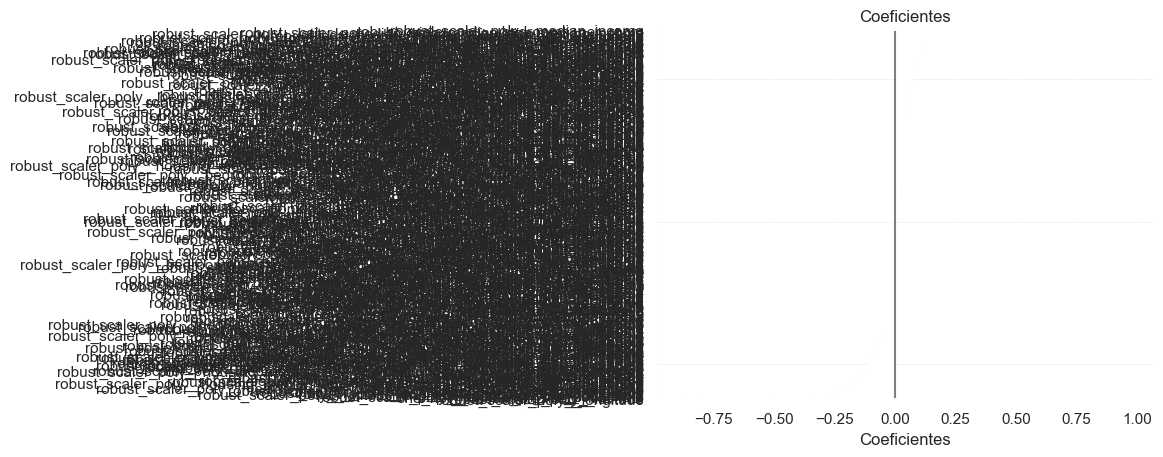

In [16]:
plot_coeficientes(coefs)

In [17]:
coefs[coefs["coeficiente"] == 0] # Ainda temos uma regularização Lasso, então podemos ver que alguns coeficientes foram zerados.

,coeficiente


In [18]:
coefs[coefs["coeficiente"].between(-0.2, 0.2)]

,coeficiente
one_hot__ocean_proximity_NEAR BAY,-0.197388
robust_scaler_poly__longitude^2 rooms_per_household,-0.176539
robust_scaler_poly__latitude^2 population,-0.172977
robust_scaler_poly__housing_median_age median_income population_per_household,-0.171113
robust_scaler_poly__latitude^2 median_income,-0.168808
...,...
robust_scaler_poly__latitude^3,0.170461
robust_scaler_poly__bedrooms_per_room median_income,0.173785
robust_scaler_poly__longitude median_income population_per_household,0.186856
robust_scaler_poly__latitude^2 longitude,0.187673


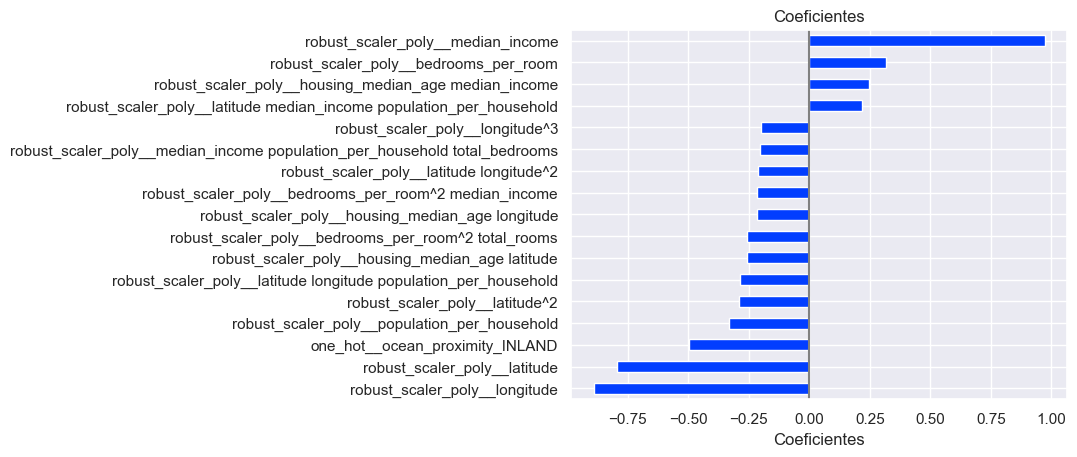

In [19]:
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.2, 0.2)])
# Com a regularização nós notamos que as features de maior relevância (a regularização elimina essas features com pouca relevância
# ... facilitando a explicação para o cliente.
# Daí as features que envolvem renda e localização aparecem

In [20]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "Ridge_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.003011,0.003353,-0.000081,-77516.042766,-96239.705692,0.006363
1,DummyRegressor,0.000999,0.0,-0.000146,-75787.787194,-95217.629397,0.000999
2,DummyRegressor,0.0,0.006872,-0.001737,-76753.598961,-96253.253947,0.006872
3,DummyRegressor,0.0,0.0,-0.000101,-76837.804811,-95983.885799,0.0
4,DummyRegressor,0.00793,0.002006,-0.000114,-76617.245449,-96182.764729,0.009936
5,LinearRegression,0.009122,0.01567,0.682162,-39855.690996,-54254.958188,0.024792
6,LinearRegression,0.023891,0.001874,0.66999,-40272.565467,-54695.230283,0.025766
7,LinearRegression,0.01506,0.015774,0.649247,-42178.05929,-56955.988706,0.030834
8,LinearRegression,0.015691,0.0,0.669873,-40806.492497,-55146.318803,0.015691
9,LinearRegression,0.015904,0.015728,0.669023,-40788.496497,-55331.35106,0.031632


* Notamos uma melhora nas métricas, mas o tempo aumenta consideravelmente (O modelo fica mais pesado)

In [21]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002388,0.002446,-0.000436,-76702.495836,-95975.447913,0.004834
LinearRegression,0.015934,0.009809,0.668059,-40780.26095,-55276.769408,0.025743
LinearRegression_target,0.030336,0.001728,0.678052,-38680.673775,-54434.401717,0.032064
Ridge_grid_search,0.886346,0.011321,0.723439,-35368.533295,-50443.686489,0.897667


In [22]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002388,0.002446,-0.000436,-76702.495836,-95975.447913,0.004834
LinearRegression,0.015934,0.009809,0.668059,-40780.26095,-55276.769408,0.025743
LinearRegression_target,0.030336,0.001728,0.678052,-38680.673775,-54434.401717,0.032064
Ridge_grid_search,0.886346,0.011321,0.723439,-35368.533295,-50443.686489,0.897667


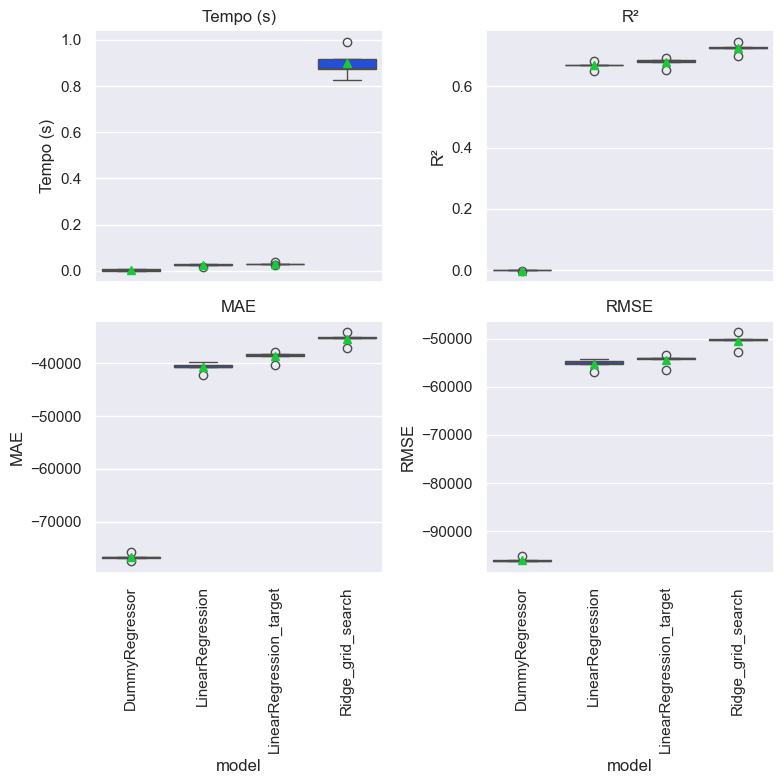

In [23]:
plot_comparar_metricas_modelos(df_resultados) # O tempo ficou alto, mas bem mais baixo que o da ElasticNet e ainda melhorou a métrica.

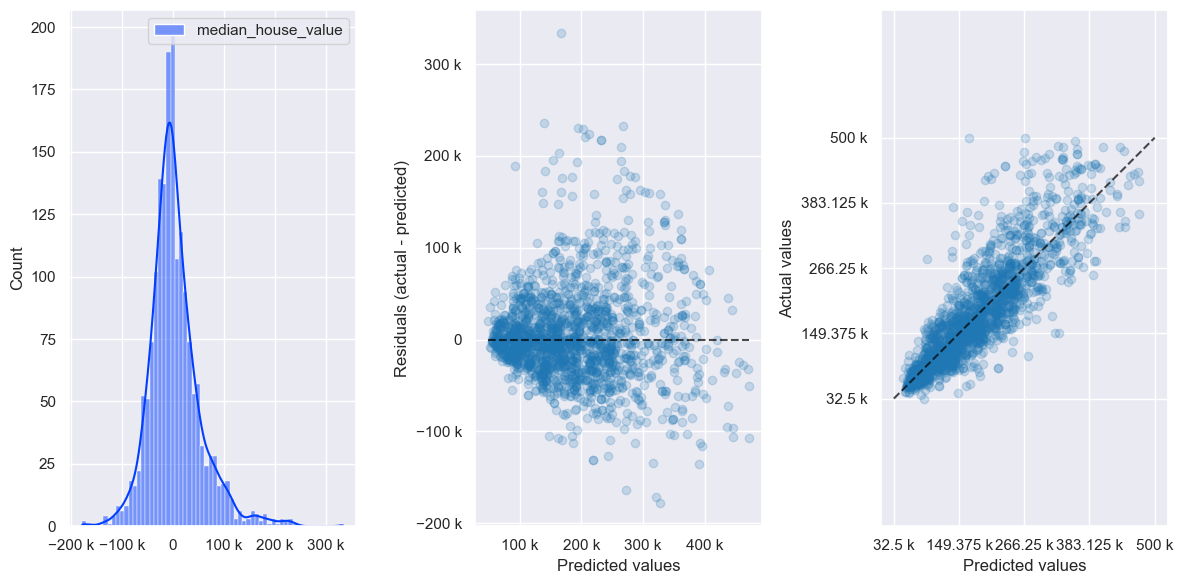

In [24]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)